En aquest codi analitzarem els resultats de cada partida i escriurem les classificacions corresponents.

In [142]:
# Importem les llibreries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr # per guardar les dades 3D
from collections import Counter

In [136]:
# Definim tab20 com la paleta per defecte dels plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [4]:
# Carreguem les dades
data_df = pd.read_csv('results.csv')

# Emplenem els espais en blanc amb 0
data_df = data_df.fillna(0.)

In [13]:
# Obtenim una llista amb tots els noms dels participants
players_names = np.unique(data_df[['Jugador 1', 'Jugador 2', 'Jugador 3', 'Jugador 4']].values.flatten())

# Llista de dies jugats
matchdays = pd.unique(data_df['D'])

In [61]:
# Comptem quants partits ha jugat cada participant
all_players = data_df['Jugador 1'].tolist() + data_df['Jugador 2'].tolist() + data_df['Jugador 3'].tolist() + data_df['Jugador 4'].tolist()

games_count = dict(Counter(all_players))
print(games_count.items())
games_played_df = pd.DataFrame(games_count.items(), columns=['Player', 'Games played'])
games_played_df

dict_items([('Dani', 51), ('Guille', 42), ('Antía', 26), ('Pau', 30), ('Clàudia', 2), ('Maider', 36), ('Luis', 48), ('Víctor', 14), ('Alejandro', 3), ('Pedro', 17), ('Simone', 1), ('Elena', 5), ('Rebeca', 5), ('Tiziano', 2), ('Pablo', 2)])


,Player,Games played
0,Dani,51
1,Guille,42
2,Antía,26
3,Pau,30
4,Clàudia,2
5,Maider,36
6,Luis,48
7,Víctor,14
8,Alejandro,3
9,Pedro,17


In [141]:
# En aquest dataframe hi guardem les estadístiques finals després de cada jornada
winplayed_matchdays = pd.DataFrame(columns=players_names)

for nmatchday in range(len(matchdays)):
    # Initialize an empty dictionary to store win counts
    win_counts = {}
    played_counts = {}
    winplayed_counts = {}
    
    for player in players_names: # set all initial wins to 0
        win_counts[player] = 0

    # Select matchdays
    matchday_df = data_df.loc[data_df['D'] <= nmatchday+1]
    
    # Home wins
    home_wins = matchday_df[matchday_df['Local'] > matchday_df['Visitant']]
    for player in home_wins['Jugador 1'].tolist() + home_wins['Jugador 2'].tolist():
        win_counts[player] = win_counts.get(player, 0) + 1
    
    # Away wins
    away_wins = matchday_df[matchday_df['Visitant'] > matchday_df['Local']]
    for player in away_wins['Jugador 3'].tolist() + away_wins['Jugador 4'].tolist():
        win_counts[player] = win_counts.get(player, 0) + 1

    # Games played
    for player in players_names:
        # Comptem quantes vegades el nom del jugador apareix al registre de partits
        games_played = (matchday_df[['Jugador 1', 'Jugador 2', 'Jugador 3', 'Jugador 4']] == player).sum().sum()

        # Desem a un diccionari el recompte de partits jugats
        played_counts[player] = games_played

        # Desem a un diccionari la ràtio entre partits guanyats i partits jugats
        if games_played == 0:
            winplayed_counts[player] = 0
        else:
            winplayed_counts[player] = win_counts.get(player, 0) / games_played
        
        #print(player)
        #win_counts[player] = win_counts.get(player, 0) / 
    
    # Create dataframe with results of this matchday
    matchday_ratio = pd.DataFrame(winplayed_counts.items()).transpose().reset_index(drop=True) # la llista vertical de resultats per jugador, la passem a fila
    matchday_ratio.columns = matchday_ratio.iloc[0] # definim que els noms de la columna són els noms dels jugadors (que surten a la 1a fila)
    matchday_ratio = matchday_ratio.drop(matchday_ratio.index[0]) #esborrem la primera fila, que conté els noms del jugadors
    
    # Agrupem els resultats d'aquesta jornada amb els de les anteriors (columna = nom jugador; fila = matchday)
    winplayed_matchdays = pd.concat([winplayed_matchdays, matchday_ratio], ignore_index=True)

# Convert to DataFrame for display
#win_counts_df = pd.concat(pd:winDataFrame(list(win_counts.items()), columns=['Player', 'WinCount'])
# winplayed_matchdays
#win_counts_df

Desem les dades a un xarray. Aquest format permet emmagatzemar matrius 3D, cosa que pandas no ho permet. A la nostra matriu tindrem dimensions (Nom de jugador, Dia de partit, Paràmetre). Això ens permet accedir a l'element que deseitgem.

In [147]:
# Creem una DataArray de xarray. Hi especifiquem els noms de cada dimensió
winplayed_matchdays_da = xr.DataArray(winplayed_matchdays.values, dims = ('Matchday', 'Player'),
                                      coords = {'Matchday': winplayed_matchdays.index, 'Player': winplayed_matchdays.columns})

# Combinem tots els DataArrays a un únic Dataset de xarray (cal que les coords siguin les mateixes per a tots)
dataset = xr.Dataset({"WinPlayed": winplayed_matchdays_da})
# dataset['goals'] = goals_da # si volem afegir un nou element
dataset

<xarray.Dataset> Size: 2kB
Dimensions:    (Matchday: 11, Player: 15)
Coordinates:
  * Matchday   (Matchday) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * Player     (Player) object 120B 'Alejandro' 'Antía' ... 'Tiziano' 'Víctor'
Data variables:
    WinPlayed  (Matchday, Player) object 1kB 0.0 0.3333333333333333 ... 1.0 0.5

Desem el fitxer xarray en format netcdf4. Això ens permetrà obrir-lo amb un altre fitxer i fer-ne l'anàlisi que volguem.

In [150]:
dataset.to_netcdf('stats.nc')
# ds = xr.open_dataset('stats.nc', engine ='netcdf4') # si volem obrir el fitxer

ValueError: invalid format for scipy.io.netcdf backend: 'NETCDF4'

Text(0, 0.5, 'Games won / Games played')

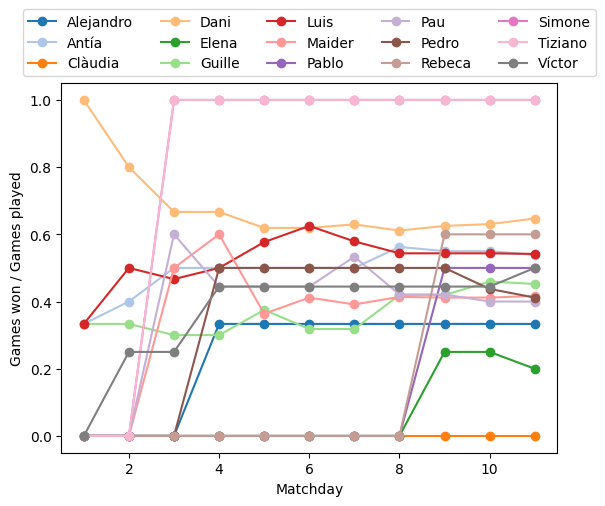

In [135]:
# Pintem el nombre de partits jugats
# Plot each column manually using the index as x-axis
for player in winplayed_matchdays.columns:
    plt.plot(matchdays, winplayed_matchdays[player].to_numpy(), marker='o', label=player)

plt.legend(bbox_to_anchor = ( 0.5, 1.), ncol = 5, loc = 'lower center')
plt.xlabel("Matchday")
plt.ylabel("Games won / Games played")